In [1]:
#Load required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import math
%matplotlib agg
from matplotlib import cm
import os
import warnings
warnings.filterwarnings("ignore")

# Data Preparation

The datasets are composed of the following columns (KPIs and scenario attributes).

**day_num**<br>
The day number is the start day number of the two-week simulation. 

**test_day**<br>
The day type of the start day, including typical testdays, e.g., peak_heat_day, typical_heat_day, peak_heat_day, typical_cool_day, mix_day and benchmarking testdays, e.g., cool_day_1, heat_day_1, other_day_1. 

**test_case**<br>
The name of the testcase: bestest_air, bestest_hydronic, bestest_hydronic_heat_pump, multizone_office_simple_air,
        multizone_residential_hydronic, singlezone_commercial_hydronic

**tdis_tot**<br>
The thermal discomfort is the integral of the deviation of the temperature with respect to the predefined comfort setpoint. Its units are of K*h/zone.

**idis_tot**<br>
The IAQ discomfort is the integral of the deviation of the CO2 concentration with respect to the predefined comfort setpoint. Its units are of ppm*h/zone.

**ener_tot**<br>
The total building energy use by floor area in kWh/m^2  when accounting for the sum of all energy vectors present in the test case.

**cost_tot**<br>
The total building operational energy cost by floor area in ($ or euros)/m^2 when accounting for the sum of all energy vectors present in the test case as well as other sources of cost like water.

**emis_tot**<br>
The total building emissions by floor area in kgCO2/m^2 when accounting for the sum of all energy vectors present in the test case.

**pele_tot**<br>
The total peak 15-minute electricity demand by floor area in kW/m^2.

**pgas_tot**<br>
The total peak 15-minute gas demand by floor area in kW/m^2.

**pdih_tot**<br>
The total peak 15-minute district heating demand by floor area in kW/m^2.

**time_rat**<br>
The computational time ratio as the average ratio between the elapsed control time and the test case control step time. The elapsed control time is measured as the time between two emulator simulations. A time counter starts at the end of the 'advance' test case method and finishes at the beginning of the following call to the same method. Notice that the accounted time includes not only the controller computational time but also the signal exchange time with the controller through the RESTAPI interface.

In [2]:
def read_data_to_df(testcasename):
    '''Read raw KPI data from csv
    Parameters
    ----------
    testcasename: str
        Testcase name:'bestest_air','bestest_hydronic','bestest_hydronic_heat_pump','multizone_office_simple_air',
        'multizone_residential_hydronic','twozone_apartment_hydronic', 'singlezone_commercial_hydronic'
        
    Returns
    -------
    df_testcase: DataFrame
        KPI dataframe results of the testcase
    '''
    # Read KPI results spreadsheets
    filepath = os.path.join("csv", f"df_kpi_{testcasename}.csv")
    df_testcase = pd.read_csv(filepath)
    
    # Round decimals for each KPI
    round_decimals = {'tdis_tot': 1, 'idis_tot': 1, 'ener_tot': 2, 'cost_tot': 3,
                      'emis_tot': 2, 'pele_tot': 3, 'pgas_tot': 3, 'pdih_tot': 2,
                      'time_rat': 6}
    df_testcase = df_testcase.round(round_decimals)
    
    # Break scenarios column into time_period and energy price signal
    df_testcase[['price', 'day_num']] = df_testcase['Scenario'].str.split('+', expand=True)
    df_testcase['testcase'] = testcasename
    df_testcase.drop(columns=['Scenario'], inplace=True)

    return df_testcase

In [3]:
#By model KPI results
df_kpi_bestest_air=read_data_to_df('bestest_air')
df_kpi_bestest_hydronic=read_data_to_df('bestest_hydronic')
df_kpi_bestest_hydronic_heat_pump=read_data_to_df('bestest_hydronic_heat_pump')
df_kpi_multizone_office_simple_air=read_data_to_df('multizone_office_simple_air')
df_kpi_multizone_residential_hydronic=read_data_to_df('multizone_residential_hydronic')
df_kpi_twozone_apartment_hydronic=read_data_to_df('twozone_apartment_hydronic')
df_kpi_singlezone_commercial_hydronic=read_data_to_df('singlezone_commercial_hydronic')
df_kpi_singlezone_commercial_hydronic.head()

#All the KPI results
df_kpi_all=pd.concat([df_kpi_bestest_air,df_kpi_bestest_hydronic,df_kpi_bestest_hydronic_heat_pump,
                     df_kpi_multizone_office_simple_air,df_kpi_multizone_residential_hydronic,
                     df_kpi_twozone_apartment_hydronic, df_kpi_singlezone_commercial_hydronic],
                     axis=0,ignore_index=True)
df_kpi_all.head()

#Filter the dateframe to typical test days
typicaltestdays=['peak_heat_day', 'typical_heat_day', 'peak_cool_day', 'typical_cool_day', 'mix_day']
df_kpi_all_testdays=df_kpi_all[df_kpi_all['test_day'].isin(typicaltestdays)]

df_kpi_all_testdays.head()

,test_day,cost_tot,emis_tot,ener_tot,idis_tot,pdih_tot,pele_tot,pgas_tot,tdis_tot,time_rat,price,day_num,testcase
0,peak_heat_day,0.023,0.79,3.72,1219.7,NaN,0.010,0.121,5.7,0.000259,constant,Day341,bestest_air
1,typical_heat_day,0.032,0.71,2.69,1219.7,NaN,0.017,0.104,5.6,0.000032,constant,Day51,bestest_air
2,peak_cool_day,0.121,1.47,2.23,1222.1,NaN,0.033,0.022,7.7,0.000037,constant,Day289,bestest_air
3,typical_cool_day,0.060,0.73,1.10,1222.6,NaN,0.015,0.000,4.3,0.000036,constant,Day153,bestest_air
4,mix_day,0.043,0.89,3.18,1220.2,NaN,0.023,0.117,5.7,0.000033,constant,Day21,bestest_air


In [4]:
def typical_scenario_table(testname, df_testcase,have_unit=False):
    
    '''Dataframe that shows the KPI results of the typical scenarios and benchmark average data
    ----------
    testcasename: str
        Testcase name:'bestest_air','bestest_hydronic','bestest_hydronic_heat_pump','multizone_office_simple_air',
        'multizone_residential_hydronic','singlezone_commercial_hydronic'
    df_testcase: DataFrame
        Whole KPI dtaframe results of the testcase
        
    Returns
    -------
    df_testcase_typical_scenario: DataFrame
        KPI dataframe results of the testcase under the typical scenarios
    '''

    if testname =='bestest_air' or testname =='multizone_office_simple_air':
        #Filter out typical test days
        typicaltestdays=['peak_heat_day', 'typical_heat_day', 'peak_cool_day', 'typical_cool_day', 'mix_day']
        #Get average KPI on heating month, cooling month, and all day
        heat_month_avg=pd.concat([df_testcase[df_testcase['test_day'].str.startswith('heat_day')].mean(numeric_only=True),
                                  pd.Series({'price':'NA','day_num':'NA', 'test_day':'heat_month_average','testcase':testname})],axis=0)
        cool_month_avg=pd.concat([df_testcase[df_testcase['test_day'].str.startswith('cool_day')].mean(numeric_only=True),
                                  pd.Series({'price':'NA','day_num':'NA','test_day':'cool_month_average','testcase':testname})],axis=0)
        all_avg=pd.concat([df_testcase.mean(numeric_only=True),
                           pd.Series({'price':'NA','day_num':'NA','test_day':'annual_average','testcase':testname})],axis=0)
        df_testcase_typical_scenario=df_testcase[df_testcase['test_day'].isin(typicaltestdays)]
        df_testcase_typical_scenario=pd.concat([df_testcase_typical_scenario, pd.DataFrame(heat_month_avg).transpose(), 
                pd.DataFrame(cool_month_avg).transpose(), pd.DataFrame(all_avg).transpose()],axis=0,ignore_index=True)
    else:
        typicaltestdays=['peak_heat_day', 'typical_heat_day']
        #Get average KPI on heating month
        heat_month_avg=pd.concat([df_testcase[df_testcase['test_day'].str.startswith('heat_day')].mean(numeric_only=True),
                                  pd.Series({'price':'NA','test_day':'heat_month_average','testcase':testname})],axis=0)
        df_testcase_typical_scenario=df_testcase[df_testcase['test_day'].isin(typicaltestdays)]
        df_testcase_typical_scenario=pd.concat([df_testcase_typical_scenario, pd.DataFrame(heat_month_avg).transpose()],
                                               axis=0,ignore_index=True)
    # Round KPI results
    kpi_cols = ['cost_tot','emis_tot','ener_tot','idis_tot','pdih_tot','pele_tot','pgas_tot',
            'tdis_tot','time_rat']    
    df_testcase_typical_scenario.loc[:,kpi_cols]=df_testcase_typical_scenario.loc[:,kpi_cols].astype(float).round({'tdis_tot': 1, 
     'idis_tot': 1, 'ener_tot': 2, 'cost_tot': 3, 'emis_tot': 2, 'pele_tot': 3, 'pgas_tot': 3, 'pdih_tot': 2, 'time_rat': 6})
    # Recolumn
    cols = ['test_day','day_num','price','cost_tot','emis_tot','ener_tot','idis_tot','pdih_tot','pele_tot','pgas_tot',
            'tdis_tot','time_rat']
    df_testcase_typical_scenario=df_testcase_typical_scenario[cols]
    if have_unit:
        df_unit = pd.DataFrame([['','','','($ or Euro)/$m^2$','kg$CO_2$/$m^2$','kWh/$m^2$','ppm*h/zone','kW/$m^2$','kW/$m^2$','kW/$m^2$','K*h/zone','1']], 
                               columns=['test_day','day_num','price','cost_tot','emis_tot','ener_tot','idis_tot','pdih_tot',
                                        'pele_tot','pgas_tot','tdis_tot','time_rat'],index=['unit'])
        df_testcase_typical_scenario=pd.concat([df_unit,df_testcase_typical_scenario])    
    return df_testcase_typical_scenario



In [5]:
def typical_scenario_scatterplot(testname, df_testcase):
    
    '''Scatterplot that shows the KPI results of the typical scenarios and benchmark average data
    ----------
    testcasename: str
        Testcase name:'bestest_air','bestest_hydronic','bestest_hydronic_heat_pump','multizone_office_simple_air',
        'multizone_residential_hydronic',''twozone_apartment_hydronic', 'singlezone_commercial_hydronic'
    df_testcase: DataFrame
        Whole KPI dtaframe results of the testcase
        
    Returns
    -------
    fig_scatter: figure
        Scatterplot that shows the KPI results of the typical scenarios and benchmark average data
    '''
    df_testcase_typical_scenario=typical_scenario_table(testname, df_testcase)
    kpi_name_lst = [['tdis_tot'], ['idis_tot'], ['ener_tot'], ['cost_tot'], ['emis_tot'], ['pele_tot'],
           ['pgas_tot'], ['pdih_tot'], ['time_rat']]
    y_label_lst=['K*h/zone','ppm*h/zone','kWh/$m^2$','($ or Euro)/$m^2$','$kgCO_2$/$m^2$','$kW/m^2$','$kW/m^2$', '$kW/m^2$','']
    colors = ["gray","r","y","g","c","b","m","k","brown"]
    fig, axes = plt.subplots(3,3, figsize=(18, 12))
    axes = axes.flatten()
    for i, kpi_name in enumerate(kpi_name_lst):
        g=sns.scatterplot(ax=axes[i],data=df_testcase_typical_scenario,x='test_day',y=kpi_name[0], hue='price',
                          color=colors[0], s=150)
        fig.canvas.draw()
        xlabels = ['\n'.join(t.get_text().split('_')) for t in axes[i].get_xticklabels()]
        axes[i].set_xticks(axes[i].get_xticks())
        axes[i].set_xticklabels(xlabels, alpha=0.8)
        axes[i].set_title(kpi_name[0],fontweight='bold')
        axes[i].set_ylabel(y_label_lst[i])
        legend_labels, _= g.get_legend_handles_labels()
        if i== 4:
            axes[i].legend(legend_labels, ['constant','dynamic','highly dynamic','all'],title='Price',loc='best')
        else:
            axes[i].legend(legend_labels, [],frameon=False,)
    fig.subplots_adjust(hspace=0.6, wspace=0.2)
    
    return fig

In [6]:
def typical_scenario_statistic(testname, df_testcase):
    
    '''Dataframe that shows the statistics of KPI results
    ----------
    testcasename: str
        Testcase name:'bestest_air','bestest_hydronic','bestest_hydronic_heat_pump','multizone_office_simple_air',
        'multizone_residential_hydronic','twozone_apartment_hydronic', 'singlezone_commercial_hydronic'
    df_testcase: DataFrame
        Whole KPI dtaframe results of the testcase
        
    Returns
    -------
    df_testcase_statistic: DataFrame
        KPI statistics results of the testcase under the typical scenarios
    '''
    df_testcase_statistic=df_testcase.iloc[:,1:10].describe().loc[['mean','std','min','25%','50%','75%','max',
            'count']].round({'tdis_tot': 1, 'idis_tot': 1, 'ener_tot': 2, 'cost_tot': 3, 'emis_tot': 2, 
                             'pele_tot': 3, 'pgas_tot': 3, 'pdih_tot': 2, 'time_rat': 6})

    df_unit = pd.DataFrame([['($ or Euro))/$m^2$','kg$CO_2$/$m^2$','kWh/$m^2$','ppm*h/zone','kW/$m^2$','kW/$m^2$','kW/$m^2$','K*h/zone','1']], 
                           columns=['cost_tot','emis_tot','ener_tot','idis_tot','pdih_tot',
                                    'pele_tot','pgas_tot','tdis_tot','time_rat'],index=['unit'])
    df_testcase_statistic=pd.concat([df_unit,df_testcase_statistic])
    return df_testcase_statistic

In [7]:
def typical_scenario_boxplot(testname, df_testcase):
    
    '''Boxplot that shows the KPI results of the typical scenarios and benchmark distributions
    ----------
    testcasename: str
        Testcase name:'bestest_air','bestest_hydronic','bestest_hydronic_heat_pump','multizone_office_simple_air',
        'multizone_residential_hydronic', 'twozone_apartment_hydronic', 'singlezone_commercial_hydronic'
    df_testcase: DataFrame
        Whole KPI dtaframe results of the testcase
        
    Returns
    -------
    fig_box: figure
        Boxplot that shows the KPI results of the typical scenarios and benchmark distributions
    '''
    palette ={"peak_heat_day": "red", "typical_heat_day": "salmon", "peak_cool_day": "b", "typical_cool_day": "lightblue",
             "mix_day": "yellowgreen", "heat_month_average": "lightcoral", "cool_month_average": "steelblue", "annual_average": "gray"}
    kpi_name_lst = [['tdis_tot'], ['idis_tot'], ['ener_tot'], ['cost_tot'], ['emis_tot'], ['pele_tot'],
           ['pgas_tot'], ['pdih_tot'], ['time_rat']]
    y_label_lst=['K*h/zone','ppm*h/zone','kWh/$m^2$','($ or Euro)/$m^2$','$kgCO^2$/$m^2$','$kW/m^2$','$kW/m^2$', '$kW/m^2$','']

    df_testcase_typical_scenario=typical_scenario_table(testname, df_testcase)
    
    fig, axes = plt.subplots(3,3,figsize=(9,12))
    axes=axes.ravel()

    for i, col in enumerate(kpi_name_lst):
        axes[i]=sns.boxplot(ax=axes[i],y=df_testcase[col[0]],color='white',fliersize=0,showfliers=False)
        sns.scatterplot(ax=axes[i],data=df_testcase_typical_scenario,x=0,y=df_testcase_typical_scenario[col[0]],
                        hue ="test_day", alpha=1, s=150,palette=palette)
        if math.isnan(df_testcase[col[0]].min()):
            continue
        else:
            Q1 = df_testcase[col[0]].quantile(0.25)
            Q3 = df_testcase[col[0]].quantile(0.75)
            IQR = Q3 - Q1
            axes[i].set_ylim(Q1 - 1.6 * IQR, Q3 + 1.6 *IQR)
            
        axes[i].set_ylabel(y_label_lst[i])
        axes[i].set_xlabel(col[0],fontweight='bold')
    for ax in axes:
        ax.legend([],[], frameon=False)
    handles, labels  =  axes[-1].get_legend_handles_labels()  
    axes[-1].legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(-1.2, -0.4))
    fig.subplots_adjust(hspace=0.2, wspace=0.7)
    
    return fig

In [8]:
from IPython.display import Markdown, display, HTML
display(HTML("""
<style>
.output {
    display: table-cell;
    align-items: center;
    text-align: center;
}
</style>

"""))
def printmd(string):
    display(Markdown(string))
def process_testcase(testname, df_testcase,have_unit=False):
    '''Main function to process and display all the testcase KPI results
    ----------
    testcasename: str
        Testcase name:'bestest_air','bestest_hydronic','bestest_hydronic_heat_pump','multizone_office_simple_air',
        'multizone_residential_hydronic', 'twozone_apartment_hydronic', 'singlezone_commercial_hydronic'
    df_testcase: DataFrame
        Whole KPI dtaframe results of the testcase
        
    '''
    if testname =='bestest_air' or testname =='multizone_office_simple_air':
        printmd('The baseline testing results for the typical days is tabulated in the \
        following table and depicted in the scatterplot. To provide a convincing benchmark, the heating month average, \
        cooling month average, and annual average for different KPIs are provided in the last three rows. \
        For a specific sceanrio (e.g., constant+peak_cool_day), one could compare the customized controller performance \
        with the baseline case results (row 2). In addition, the cooling month average (row 16) and annual average results \
        could be compared (row 17).')
    else:
        printmd('The baseline testing results for the typical days is tabulated in the following table and \
        depicted in the scatterplot. To provide a convincing benchmark, the heating month average for different KPIs is \
        provided in the last row. For a specific sceanrio (e.g., constant+peak_heat_day), one could compare the customized \
        controller performance with the baseline case results (row 0). In addition, the heating month average results could \
        be compared (row 6).')
    
    #KPI results for typical scenarios and average benchmark scenarios
    printmd('<center>Typical Day Testing Result Table for Testcase {} </center>'.format(testname))
    df1=typical_scenario_table(testname,df_testcase,have_unit=True)
    display(df1)
    #Scatterplot
    printmd('<center>Scatterplot of Typical Day Testing Results for Testcase {} </center>'.format(testname))
    f1=typical_scenario_scatterplot(testname,df_testcase)
    display(f1)
    plt.close() 
    
    printmd('The following table shows the statistics of the KPIs for Testcase {} and the boxplot shows the distribution \
    of different KPIs with the typical day results annotated. From there, one could benchmark some hard-to-judge KPIs from \
    the statistics and distributions.'.format(testname))
    
    #KPI statistic table
    printmd('<center>Statistic Summary Table of All Scenarios for Testcase {} </center>'.format(testname))
    df2=typical_scenario_statistic(testname,df_testcase)
    display(HTML(df2.to_html()))
    printmd('<center>Boxplot of All-Scenario Testing Results for Testcase {} </center>'.format(testname))
    f2=typical_scenario_boxplot(testname,df_testcase)
    display(f2)
    plt.close()

# Results

## By testcase results

For each testcase, the baseline testing results are visualized by a scatterplot and a boxplot to show the KPI ranges in different scenarios.

### bestest_air

In [ ]:
process_testcase('bestest_air',df_kpi_bestest_air)

### multizone_office_simple_air

In [ ]:
process_testcase('multizone_office_simple_air',df_kpi_multizone_office_simple_air)

### bestest_hydronic

In [ ]:
process_testcase('bestest_hydronic',df_kpi_bestest_hydronic)

### bestest_hydronic_heat_pump

In [ ]:
process_testcase('bestest_hydronic_heat_pump',df_kpi_bestest_hydronic_heat_pump)

### multizone_residential_hydronic

In [ ]:
process_testcase('multizone_residential_hydronic',df_kpi_multizone_residential_hydronic)

### twozone_apartment_hydronic

In [ ]:
process_testcase('twozone_apartment_hydronic',df_kpi_twozone_apartment_hydronic)

### singlezone_commercial_hydronic

In [ ]:
process_testcase('singlezone_commercial_hydronic',df_kpi_singlezone_commercial_hydronic)

## Summary tables

The following table shows the statistics of the KPIs for all the testcases. From there, one could benchmark some hard-to-judge KPIs using the baseline testing data from all the testcases. For example, the third quartile value for tdis_tot is 9.8 K*h. The testing result beyond that value probably needs further attention (e.g., doublecheck the benchmark results within the testcase).

In [16]:
df_summary_stat=df_kpi_all.loc[:,['cost_tot','emis_tot','ener_tot','idis_tot','pdih_tot',
                                'pele_tot','pgas_tot','tdis_tot','time_rat']].describe().loc[['mean','std','min','25%','50%','75%','max','count']]
df_summary_stat=df_summary_stat.round({'tdis_tot': 1, 'idis_tot': 1, 'ener_tot': 2, 'cost_tot': 3, 'emis_tot': 2, 'pele_tot': 3, 'pgas_tot': 3, 'pdih_tot': 2, 'time_rat': 5})
df_unit = pd.DataFrame([['($ or Euro)/$m^2$','kg$CO_2$','kWh/$m^2$','ppm*h/zone','kW/$m^2$','kW/$m^2$','kW/$m^2$','K*h/zone','1']], 
                       columns=['cost_tot','emis_tot','ener_tot','idis_tot','pdih_tot',
                                'pele_tot','pgas_tot','tdis_tot','time_rat'],index=['unit'])
pd.concat([df_unit,df_summary_stat])

,cost_tot,emis_tot,ener_tot,idis_tot,pdih_tot,pele_tot,pgas_tot,tdis_tot,time_rat
unit,euro,kg$CO_2$,kW*h,ppm*h,kW/$m^2$,kW/$m^2$,kW/$m^2$,K*h,1
mean,0.252,0.74,2.83,1506.0,0.09,0.018,0.068,13.2,0.00014
std,0.254,0.49,2.54,2980.9,0.0,0.011,0.044,19.3,0.00071
min,0.006,0.03,0.1,0.0,0.08,0.0,0.0,0.2,0.0
25%,0.054,0.41,1.19,0.0,0.09,0.006,0.025,4.9,0.00004
50%,0.136,0.61,2.03,90.5,0.09,0.019,0.082,6.8,0.00005
75%,0.414,0.96,3.52,1222.2,0.09,0.024,0.113,10.1,0.00017
max,1.007,2.25,12.42,14853.0,0.09,0.04,0.121,104.2,0.01774
count,3453.0,3453.0,3453.0,3453.0,279.0,3453.0,1590.0,3453.0,3453.0


## Summary figures

The following boxplots show the distribution of different KPIs with the typical day results annotated.

**KPI overall results - Boxplot**

This boxplot shows the distributions of different KPIs for all the testcases. The typical test days and associated testcases are marked. 

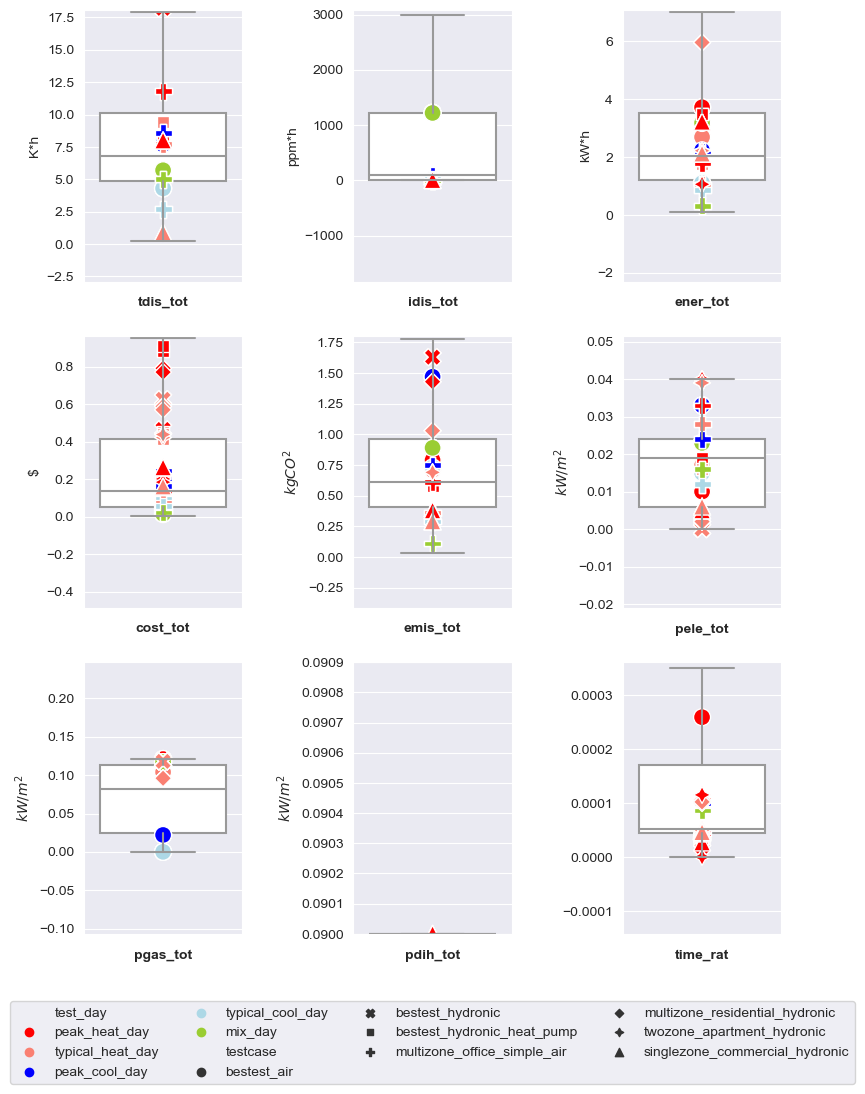

In [17]:
palette ={"peak_heat_day": "red", "typical_heat_day": "salmon", "peak_cool_day": "b", "typical_cool_day": "lightblue",
         "mix_day": "yellowgreen", "heat_month_average": "lightcoral", "cool_month_average": "steelblue", "annual_average": "gray"}
kpi_name_lst = [['tdis_tot'], ['idis_tot'], ['ener_tot'], ['cost_tot'], ['emis_tot'], ['pele_tot'],
       ['pgas_tot'], ['pdih_tot'], ['time_rat']]
y_label_lst=['K*h/zone','ppm*h/zone','$kWh/m^2$','$(\$\ or\ Euro)/m^2$','$kgCO^2/m^2$','$kW/m^2$','$kW/m^2$', '$kW/m^2$','']

fig, axes = plt.subplots(3,3,figsize=(9,12))
fig.subplots_adjust(hspace=0.2, wspace=0.7)
axes=axes.ravel()

for i, col in enumerate(kpi_name_lst):
    axes[i]=sns.boxplot(ax=axes[i],y=df_kpi_all[col[0]],color='white',fliersize=0,showfliers=False)
    sns.scatterplot(ax=axes[i],data=df_kpi_all_testdays,x=0,y=df_kpi_all_testdays[col[0]],
                    hue ="test_day",style="testcase", alpha=1, s=150, palette=palette)
    Q1 = df_kpi_all[col[0]].quantile(0.25)
    Q3 = df_kpi_all[col[0]].quantile(0.75)
    IQR = Q3 - Q1
    Q3 + 1.5 *IQR
    axes[i].set_ylim(Q1 - 1.5 * IQR, (Q3 + 1.5 *IQR)*1.01)

    axes[i].set_ylabel(y_label_lst[i])
    axes[i].set_xlabel(col[0],fontweight='bold')
for ax in axes:
    ax.legend([],[], frameon=False)
handles, labels  =  axes[-1].get_legend_handles_labels()  
axes[-1].legend(handles, labels, loc='center',ncol=4, bbox_to_anchor=(-1.2, -0.4))

display(fig)

**KPI overall results filtered by testcase**

This boxplot shows the distributions of different KPIs for each testcase. The typical test days are differentianted by colors. 

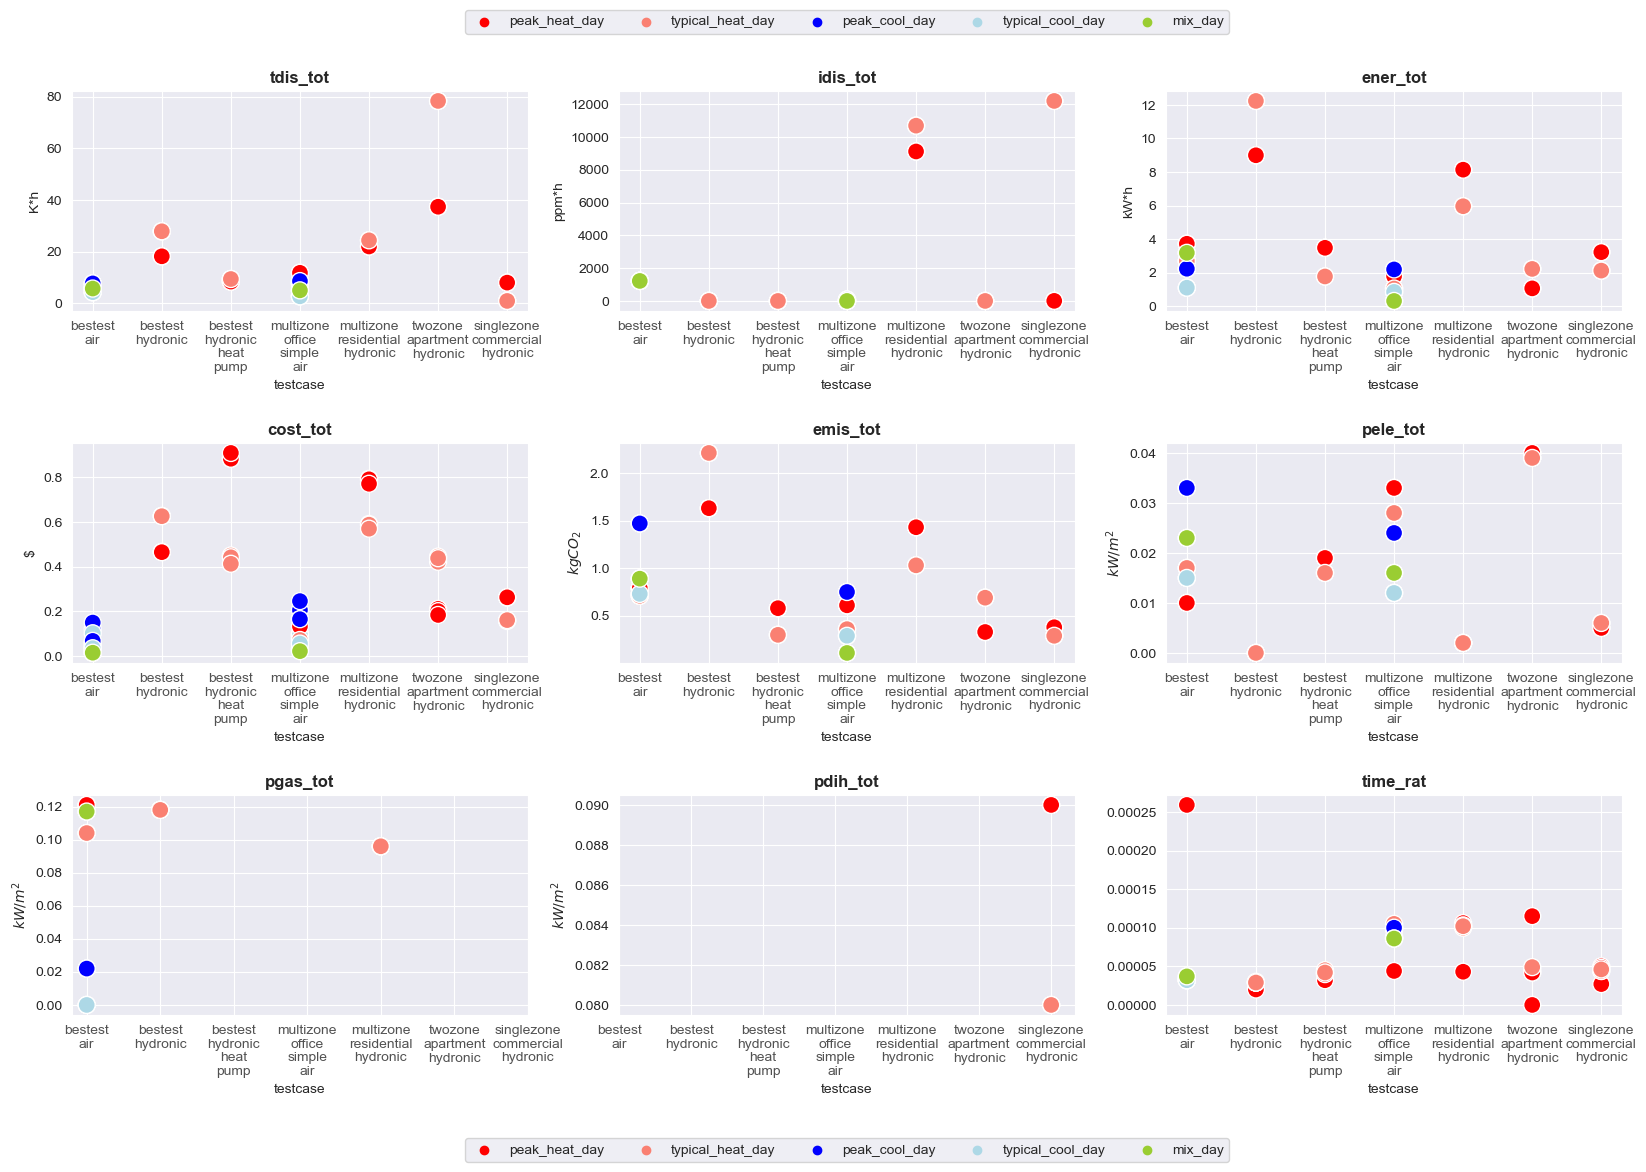

In [18]:
kpi_name_lst = [['tdis_tot'], ['idis_tot'], ['ener_tot'], ['cost_tot'], ['emis_tot'], ['pele_tot'],
       ['pgas_tot'], ['pdih_tot'], ['time_rat']]
y_label_lst=['K*h/zone','ppm*h/zone','$kWh/m^2$','$(\$\ or\ Euro)/m^2$','$kgCO^2/m^2$','$kW/m^2$','$kW/m^2$', '$kW/m^2$','']
palette ={"peak_heat_day": "red", "typical_heat_day": "salmon", "peak_cool_day": "b", "typical_cool_day": "lightblue",
         "mix_day": "yellowgreen", "heat_month_average": "lightcoral", "cool_month_average": "steelblue", "annual_average": "gray"}

fig, axes = plt.subplots(3,3, figsize=(20, 12))
axes = axes.flatten()
for i, kpi_name in enumerate(kpi_name_lst):
    #ax[i].scatter(df_kpi['testcase'],df_kpi[kpi_name[0]])
    axes[i]=sns.scatterplot(ax=axes[i],data=df_kpi_all_testdays,x='testcase',y=kpi_name[0], hue ="test_day",palette=palette, s=150)
    fig.canvas.draw()
    xlabels = ['\n'.join(t.get_text().split('_')) for t in axes[i].get_xticklabels()]
    axes[i].set_xticks(axes[i].get_xticks())
    axes[i].set_xticklabels(xlabels, alpha=0.8)
    axes[i].set_title(kpi_name[0],fontweight='bold')
    axes[i].set_ylabel(y_label_lst[i])
fig.subplots_adjust(hspace=0.6, wspace=0.2)

for ax in axes:
    ax.legend([],[], frameon=False)
handles, labels  =  axes[-1].get_legend_handles_labels()  
axes[1].legend(handles, labels, loc='upper center',ncol=5, bbox_to_anchor=(0.5, 1.4))
axes[-2].legend(handles, labels, loc='lower center',ncol=5, bbox_to_anchor=(0.5,-0.7))
display(fig)

**KPI overall results filtered by testdays**

This boxplot shows the distributions of different KPIs  for each typical test day. The testcases are differentianted by shapes and colors. 

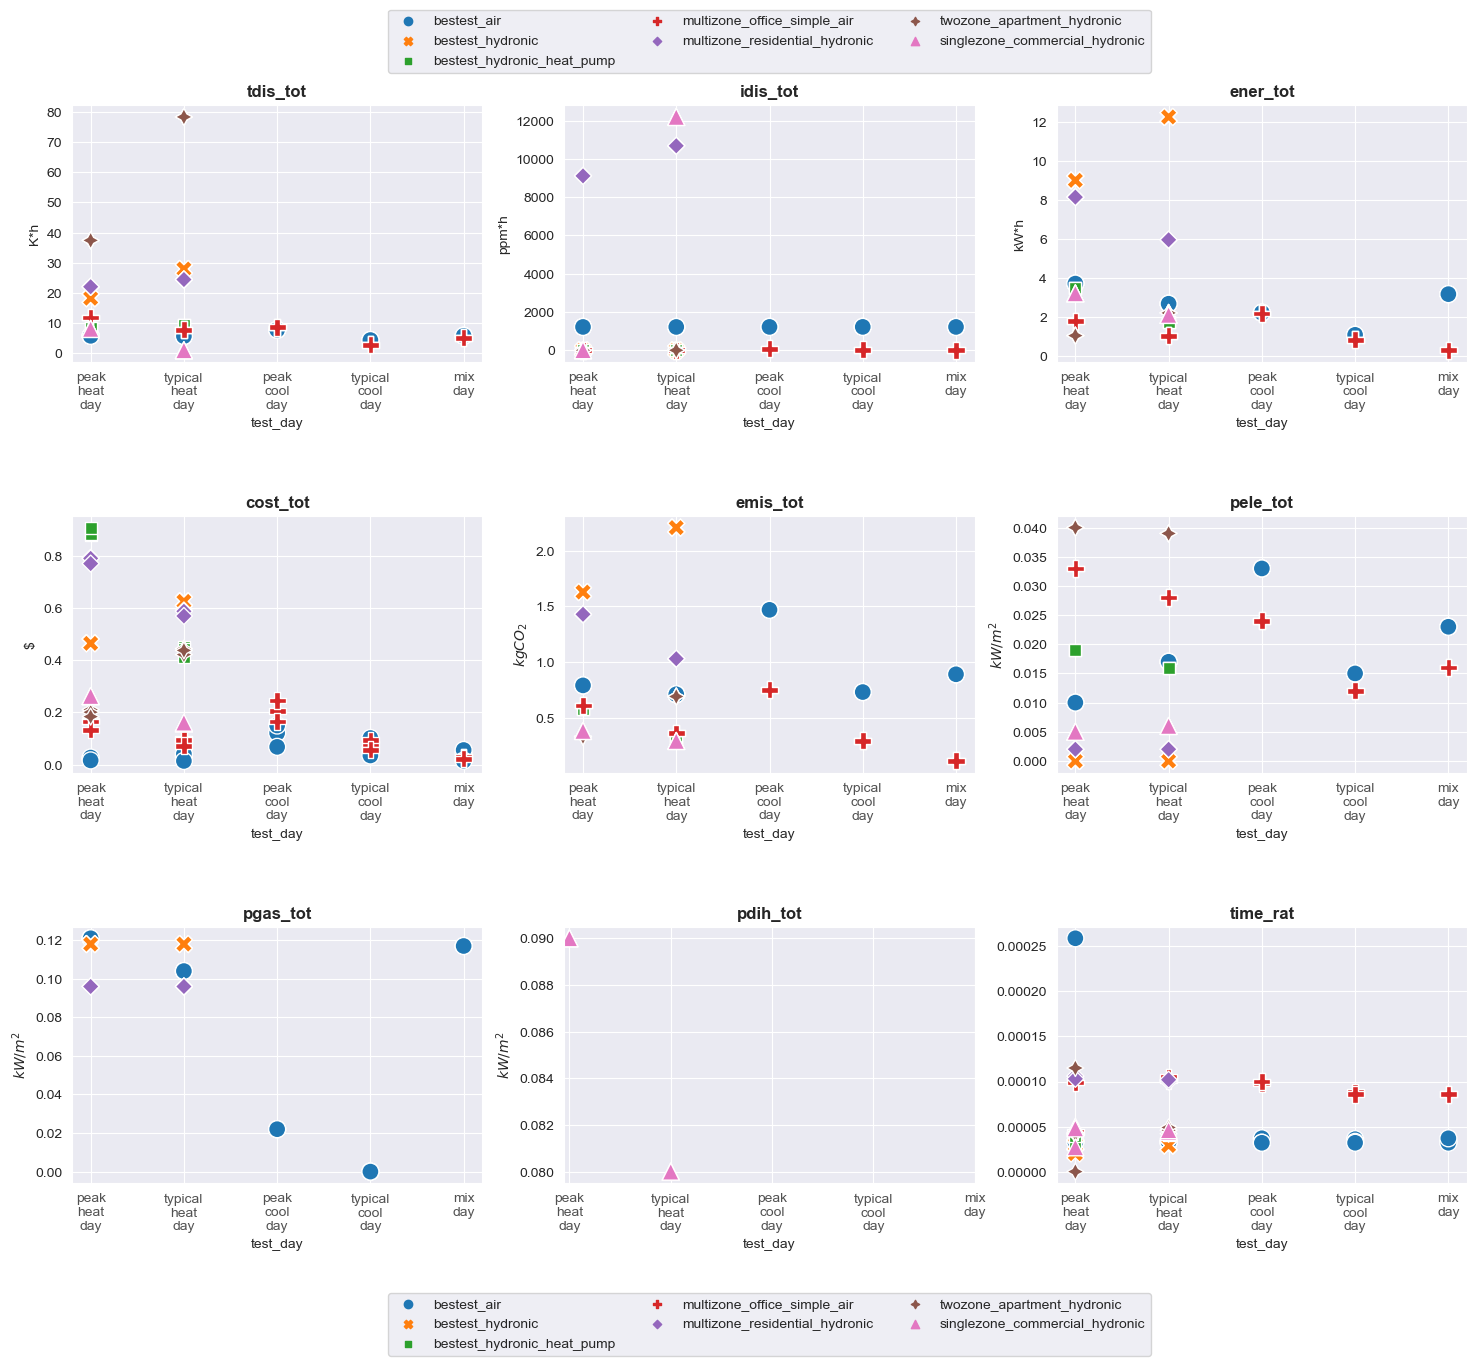

In [19]:
kpi_name_lst = [['tdis_tot'], ['idis_tot'], ['ener_tot'], ['cost_tot'], ['emis_tot'], ['pele_tot'],
       ['pgas_tot'], ['pdih_tot'], ['time_rat']]
y_label_lst=['K*h/zone','ppm*h/zone','$kWh/m^2$','$(\$\ or\ Euro)/m^2$','$kgCO^2/m^2$','$kW/m^2$','$kW/m^2$', '$kW/m^2$','']

fig, axes = plt.subplots(3,3, figsize=(18, 14))
axes = axes.flatten()
for i, kpi_name in enumerate(kpi_name_lst):
    axes[i]=sns.scatterplot(ax=axes[i],data=df_kpi_all_testdays,x='test_day',y=kpi_name[0], hue ="testcase", style = "testcase", s=150)
    fig.canvas.draw()
    xlabels = ['\n'.join(t.get_text().split('_')) for t in axes[i].get_xticklabels()]
    axes[i].set_xticks(axes[i].get_xticks())
    axes[i].set_xticklabels(xlabels, alpha=0.8)
    axes[i].set_title(kpi_name[0],fontweight='bold')
    axes[i].set_ylabel(y_label_lst[i])
fig.subplots_adjust(hspace=0.6, wspace=0.2)

for ax in axes:
    ax.legend([],[], frameon=False)
handles, labels  =  axes[-1].get_legend_handles_labels()  
axes[1].legend(handles, labels, loc='upper center',ncol=3, bbox_to_anchor=(0.5, 1.4))
axes[-2].legend(handles, labels, loc='lower center',ncol=3, bbox_to_anchor=(0.5,-0.7))

display(fig)